In [ ]:
# Source code by Zoya Bylinskii et al. with Caffe AI models : https://github.com/cvzoya/visimportance
# Adapted by Egor Abaturov to use PyTorch : https://github.com/egorabaturov/visimportance-in-pytorch
# Converted to iPython Jupyter Notebook by L. Jégou

In [17]:
import os
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from scipy.special import expit
import torch
from torch.autograd import Variable
import models
import utils
#import sys, getopt
import requests

In [18]:
# Constantes, path and files
fcn_type = 'fcn16'  # 'fcn32'
notebook_path = os.path.abspath("VisImportance.ipynb")
# Change model as desired : gdi_fcn16, gdi_fcn32 or massvis32
pretrained_model = os.path.join(os.path.dirname(notebook_path), "pretrained_models/gdi_fcn16.pth")
# Insert here the path to the source image to analyse
image_url = 'https://www.geotests.net/test/umsi/base_qa.jpg'

In [23]:
def load_img(image_url):
    img_brute = requests.get(image_url, stream=True).raw
    img = PIL.Image.open(img_brute)
    img = np.array(img, dtype=np.uint8)

    return img

def transform_img(img):
    mean_bgr = np.array([104.00699, 116.66877, 122.67892])

    img_copy = img.copy()
    img_copy = img_copy[:, :, ::-1]  # RGB -> BGR
    img_copy = img_copy.astype(np.float32)
    img_copy -= mean_bgr
    img_copy = img_copy.transpose(2, 0, 1)  # C x H x W
    img_copy = torch.from_numpy(img_copy).float()

    return img_copy

def overlay_imp_on_img(img: object, imp: object, colormap: object = 'viridis') -> object:

    cm = plt.get_cmap(colormap) # https://matplotlib.org/examples/color/colormaps_reference.html
    img2 = np.array(img, dtype=np.uint8)
    imp2 = np.array(imp, dtype=np.uint8)
    imp3 = (cm(imp2)[:, :, :3] * 255).astype(np.uint8)
    img3 = PIL.Image.fromarray(img2)
    imp3 = PIL.Image.fromarray(imp3)

    im_alpha = PIL.Image.blend(img3, imp3, 0.5)
    return(im_alpha)

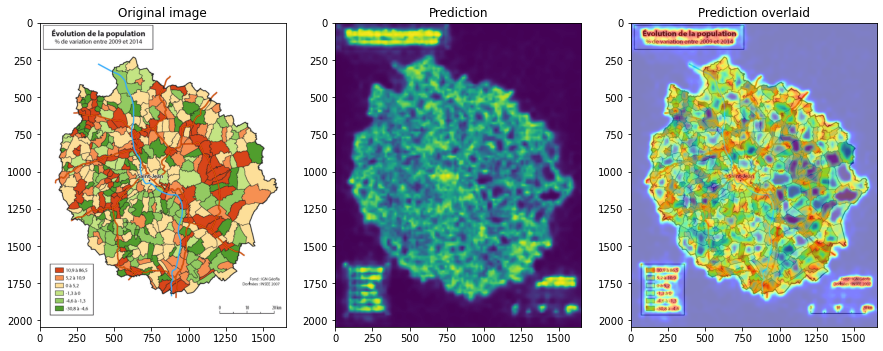

In [24]:
    img = load_img(image_url)
    img_transformed = transform_img(img)[np.newaxis]
    model = models.FCN32s() if fcn_type == 'fcn32' else models.FCN16s()
    model_weight = torch.load(pretrained_model)
    model.load_state_dict(model_weight)
    with torch.no_grad():
        img_transformed = Variable(img_transformed)
    score = model(img_transformed)
    lbl_pred = (expit(score.data.cpu().numpy()) * 255).astype(np.uint8)[0][0]

    img_overlay = overlay_imp_on_img(img, lbl_pred, colormap='jet')
    k = 3
    
    # Show
    plt.figure(figsize=[15,15])
    plt.subplot(1,k,1)
    plt.imshow(img)
    plt.title("Original image")
    plt.subplot(1,k,2)
    plt.imshow(lbl_pred)
    plt.title("Prediction")
    plt.subplot(1,k,3)
    plt.imshow(img_overlay)
    plt.title("Prediction overlaid")
    
    plt.show()